### Libraries

In [1]:
import glob
import os
import pandas as pd

import numpy as np
from tqdm import tqdm

from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss

import matplotlib.pyplot as plt

___
### Выгрузка данных 

In [2]:
survey_fcasts = pd.DataFrame()

file_type = 'csv'
seperator =','

for f in glob.glob("*." + file_type):
    if f[:13] == 'survey_fcasts':
        data = pd.read_csv(f, sep=seperator, low_memory=False, encoding='ISO-8859-1')
        survey_fcasts = pd.concat([survey_fcasts, data])
    

ifps = pd.read_csv('ifps.csv', sep=seperator, encoding='ISO-8859-1')

In [3]:
survey_fcasts.head(5)

,ifp_id,ctt,cond,training,team,user_id,forecast_id,fcast_type,answer_option,value,fcast_date,expertise,q_status,viewtime,year,timestamp
0,1004-0,1a,1,a,NaN,600.0,-200987.0,0,a,0.10,2011-08-31,1.0,closed,NaN,1,2011-08-31 16:17:18
1,1004-0,1a,1,a,NaN,600.0,-200987.0,0,b,0.90,2011-08-31,1.0,closed,NaN,1,2011-08-31 16:17:18
2,1008-0,1a,1,a,NaN,600.0,-200986.0,0,a,0.25,2011-08-31,2.0,closed,NaN,1,2011-08-31 16:18:27
3,1008-0,1a,1,a,NaN,600.0,-200986.0,0,b,0.75,2011-08-31,2.0,closed,NaN,1,2011-08-31 16:18:27
4,1006-0,1a,1,a,NaN,600.0,-200985.0,0,a,0.10,2011-08-31,3.0,closed,NaN,1,2011-08-31 16:18:47


In [4]:
ifps.head(5)

,ifp_id,q_type,q_text,q_desc,q_status,date_start,date_suspend,date_to_close,date_closed,outcome,short_title,days_open,n_opts,options
0,1001-0,0,"Will the Six-Party talks (among the US, North ...",'In' refers to any time during the remainder o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/2/12,b,Six-party talks resume,123.0,2,"(a) Yes, (b) No"
1,1002-0,0,Who will be inaugurated as President of Russia...,'In' refers to any time during the 2012 calend...,closed,9/1/11,5/14/12 0:00,5/15/12,5/6/12,b,president of Russia,248.0,3,"(a) Medvedev, (b) Putin, (c) Neither"
2,1003-0,0,Will Serbia be officially granted EU candidacy...,A 'yes' answer to this question requires not o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/3/12,b,Serbia EU candidacy,124.0,2,"(a) Yes, (b) No"
3,1004-0,0,Will the United Nations General Assembly recog...,'By' means at or prior to the end of the day o...,closed,9/1/11,9/29/11 0:00,9/30/11,9/30/11,b,UN-GA recognize Palestine,29.0,2,"(a) Yes, (b) No"
4,1005-0,0,Will Daniel Ortega win another term as Preside...,If the Nicaraguan elections do not occur in la...,closed,9/1/11,11/4/11 0:00,11/5/11,11/5/11,a,Ortega win in Nicaragua,65.0,2,"(a) Yes, (b) No"


In [5]:
q_ifps = pd.DataFrame(ifps['q_text'].unique(), columns=['questions'])
unique_q_num = q_ifps.nunique()

# show some of them
(
q_ifps.questions[0], 
q_ifps.questions[391], 
q_ifps.questions[200] 
)

('Will the Six-Party talks (among the US, North Korea, South Korea, Russia, China, and Japan) formally resume in 2011?',
 'Will **national military force(s) from one or more countries *intervene in Syria **before 1 December 2014?',
 'When will Mariano Rajoy vacate the office of Prime Minister of Spain?')

In [6]:
f'Всего вопросов : {unique_q_num[0]}'

'Всего вопросов : 527'

___
### Предсказание людей в зависимости от их ответа в прошлый год

In [7]:
user_answers = survey_fcasts[['ifp_id','user_id','q_status','year','answer_option','timestamp','value','fcast_type']]
user_answers = user_answers[(~user_answers.user_id.isna()) & (user_answers.q_status == 'closed')].reset_index(drop=True)

user_answers['ans_type'] = user_answers.ifp_id.apply(lambda x: x[5:]).astype(int)
user_answers['question'] = user_answers.ifp_id.apply(lambda x: x[:4]).astype(int)

assert user_answers.user_id.apply(lambda x: x.is_integer()).sum() == user_answers.shape[0]

user_answers['user_id'] = user_answers['user_id'].astype(int)
user_answers = user_answers.sort_values(['question','user_id'])

In [8]:
user_answers.head(2)

,ifp_id,user_id,q_status,year,answer_option,timestamp,value,fcast_type,ans_type,question
5555,1001-0,3,closed,1,a,2011-09-06 05:46:12,0.5,1,0,1001
5556,1001-0,3,closed,1,b,2011-09-06 05:46:12,0.5,1,0,1001


In [9]:
mask = (ifps.q_status == 'closed') & (ifps.n_opts == 2)
question_answers = ifps[mask][['ifp_id','outcome']]
assert question_answers.ifp_id.nunique() == question_answers.shape[0]

In [10]:
question_answers.head(2)

,ifp_id,outcome
0,1001-0,b
2,1003-0,b


In [11]:
ans = question_answers.merge(user_answers, on='ifp_id', how='left').drop(['q_status', 'ans_type', 'question','fcast_type'], axis=1)
ans.timestamp = ans.timestamp.astype('datetime64[ns]')

temp = ans.groupby(['ifp_id','user_id']).timestamp.max().reset_index()
ans = temp.merge(ans, how='left', on=['user_id','ifp_id','timestamp'])

In [12]:
#ans[(ans.ifp_id == '1047-0') & (ans.user_id == 5085)]

In [13]:
## иначе на одну дату много вариантов ответов
ans = ans.drop_duplicates()

## единственный пример где больше двух вариантов после всех упрощений 
#ans_new[(ans_new.ifp_id == '1047-0') & (ans_new.user_id == 5085)]

temp = ans.groupby(['ifp_id','user_id']).value.max().reset_index()
ans = temp.merge(ans, how='left', on=['user_id','ifp_id','value'])

In [14]:
#ans[(ans.user_id == 3) & (ans.ifp_id == '1001-0')]

### Creating features

In [15]:
## чтобы выбрать один вариант где 50% вероятность ответа
final_ans = ans.drop_duplicates(['ifp_id','user_id','value']).drop(['timestamp'], axis=1)


## оставим только тех кто больше чем в 1 год отвечал
temp = final_ans.groupby('user_id').year.nunique().reset_index()
ids_more_1_y = temp[temp.year > 1].user_id.unique()

final_ans = final_ans[final_ans.user_id.isin(ids_more_1_y)]

final_ans['outcome']       = final_ans['outcome'].replace({'a':1, 'b':0})
final_ans['answer_option'] = final_ans['answer_option'].replace({'a':1, 'b':0})


final_ans = pd.get_dummies(final_ans, columns=['user_id'])

final_ans['const'] = 1

In [16]:
for col in tqdm(final_ans.columns):
    
    if col[:4] == 'user':
        final_ans[col] = final_ans['value'] * final_ans[col]
        
# to reduce memory
final_ans.iloc[:,5:-1] = final_ans.iloc[:,5:-1].astype('float32')

100%|██████████████████████████████████████████████████████████████████████████████| 1311/1311 [01:11<00:00, 18.24it/s]


In [18]:
final_ans.head(3)

,ifp_id,value,outcome,year,answer_option,user_id_6,user_id_35,user_id_47,user_id_51,user_id_52,...,user_id_15725,user_id_15736,user_id_15755,user_id_15808,user_id_15828,user_id_15830,user_id_15836,user_id_15840,user_id_15863,const
2,1001-0,1.0,0,1,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,1001-0,0.5,0,1,1,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
14,1001-0,1.0,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Spliting dataframe on train and test

In [19]:
train_set = final_ans[final_ans.year.isin([1,2])]
test_set = final_ans[final_ans.year.isin([3,4])]

X_train, y_train = train_set.drop(['ifp_id', 'value', 'outcome', 'year', 'answer_option'], axis=1), train_set['outcome']
X_test, y_test   = test_set.drop(['ifp_id', 'value', 'outcome', 'year', 'answer_option'], axis=1), test_set['outcome']

### Scaling data

In [20]:
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)

### Fitting model and finding best hyperparameter 

In [22]:
bs = np.zeros(20)
different_C = np.geomspace(0.0000001, 0.0001, 20)

for i in tqdm(range(len(different_C))):
    clf = LogisticRegression(penalty='l2', C=different_C[i]).fit(X_train_norm, y_train)
    y_prob = clf.predict_proba(X_test_norm)[:, 1]
    
    bs[i] = brier_score_loss(y_test, y_prob)
    
bs = list(bs)
different_C = list(different_C)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:58<00:00,  2.92s/it]


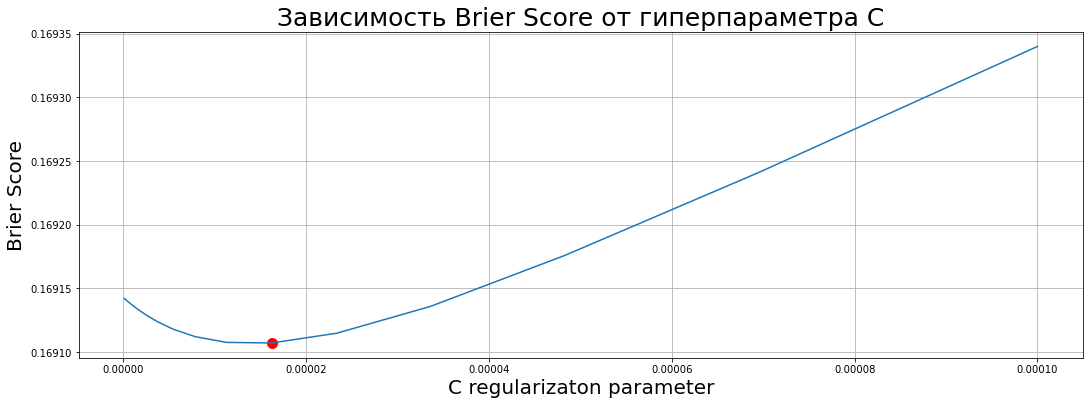

In [23]:
plt.figure(figsize=(18,6))

plt.title('Зависимость Brier Score от гиперпараметра C', fontsize=25)

plt.plot(different_C, bs)
plt.scatter(different_C[bs.index(min(bs))], min(bs), color='red', linewidths=5, alpha=1)

plt.xlabel('C regularizaton parameter', fontsize=20)
plt.ylabel('Brier Score', fontsize=20)
plt.grid()
plt.show()

In [24]:
print(f'Минимальное значение BS = {min(bs):.4f} при C = {different_C[bs.index(min(bs))]:.6f}')

Минимальное значение BS = 0.169 при C = 0.000016
